In [1]:
!aws s3 cp s3://lowresolutionhighresolution/dataset/ . --recursive

download: s3://lowresolutionhighresolution/dataset/.DS_Store to ./.DS_Store          
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/10.png to Raw Data/high_res/10.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/0.png to Raw Data/high_res/0.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/100.png to Raw Data/high_res/100.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/104.png to Raw Data/high_res/104.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/105.png to Raw Data/high_res/105.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/101.png to Raw Data/high_res/101.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/103.png to Raw Data/high_res/103.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/1.png to Raw Data/high_res/1.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/108.png

In [7]:
!pip install --upgrade pip
!pip install -U opencv-python
!apt-get upgrade
!apt-get update && apt install -y libsm6 libxext6 ffmpeg libfontconfig1 libxrender1 libgl1-mesa-glx

#!pip install tensorflow

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

print(np.__version__)
print(tf.__version__)
print(cv2.__version__)
!pip install numpy --upgrade
!pip install --upgrade tensorflow
print(tf.__version__)


/bin/sh: apt-get: command not found
/bin/sh: apt-get: command not found
1.19.5
2.4.1
4.5.1
2.4.1


In [8]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print (tf.__version__)

2.4.1


In [9]:
bucket = 'arn:aws:s3:::lowresolutionhighresolution'

import boto3
conn = boto3.client('s3')
response = conn.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(bucket["Name"])
# contents = conn.list_objects(Bucket=bucket)['Contents']
# conn.list_objects(Bucket='lowresolutionhighresolution')

Existing buckets:
aws-emr-resources-128812368847-us-west-2
aws-logs-128812368847-us-west-2
elasticbeanstalk-us-west-2-128812368847
lowresolutionhighresolution
raphaelalabi.com
sagemaker-studio-128812368847-4dx6ibast4b
videoimagescartoon


In [79]:
def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path+'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            #img = process_image(img)
            high_res_images.append(img)
        
    for dirname, _, filenames_2 in os.walk(path+'low_res'):
        for filename in filenames_2:
            if filename in filenames: # check for non-present images
                img = cv2.imread(os.path.join(dirname, filename))
                #img = process_image(img)
                low_res_images.append(img)
    
    # zero-mean and zero-center the standard deviations ....
    low_res_array = np.array(low_res_images)
    mean_centered_low_res = (low_res_array - low_res_array.mean())/low_res_array.std()
    
    # zero-mean and zero-center the standard deviations .....
    high_res_array = np.array(high_res_images)
    mean_centered_high_res = (high_res_array - high_res_array.mean())/high_res_array.std()
    
    return mean_centered_low_res, mean_centered_high_res

In [80]:
base_dir = ''
train_x, train_y =  load_data(base_dir+'train/')
val_x, val_y = load_data(base_dir+'val/')
#train_x = train_x[:-1]

In [39]:
train_small = False
if train_small:
    mask = range(0, 1)
    train_x = train_x[mask]
    train_y = train_y[mask]
print (train_x.shape, train_y.shape)

(684, 256, 256, 3) (684, 256, 256, 3)


In [45]:
train_x.shape
assert (train_x.shape[0] == train_y.shape[0]), (f"{train_x.shape[0]} {train_y.shape[0]}")

In [46]:
val_x.shape
assert (val_x.shape[0] == val_y.shape[0]), (f"{val_x.shape[0]} {val_y.shape[0]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


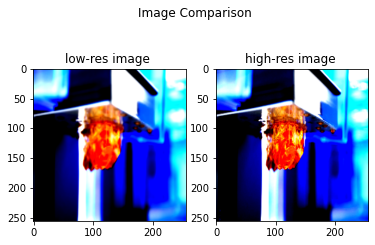

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Image Comparison')
ax1.imshow(train_x[1])
ax1.title.set_text("low-res image ")
ax2.imshow(train_y[1])
ax2.title.set_text("high-res image ")

In [ ]:

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print (tf.__version__)

In [ ]:
def build_model1():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l1)
    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l4)
    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l6)
    
    l8 = UpSampling2D()(l7)
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l9)
    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l13)
    l15 = add([l14, l2])
    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.initializers.GlorotNormal(seed=None))(l15)
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model







VAE










In [181]:
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
from tensorflow import keras

# https://keras.io/api/layers/initializers/
# The Glorot normal initializer, also called Xavier normal initializer.
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2


encoder_inputs = keras.Input(shape=(256, 256, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
    

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_84 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 128, 128, 32) 896         input_84[0][0]                   
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 64, 64, 64)   18496       conv2d_144[0][0]                 
__________________________________________________________________________________________________
flatten_36 (Flatten)            (None, 262144)       0           conv2d_145[0][0]                 
____________________________________________________________________________________________

In [182]:
# Decoder
latent_dim = 2

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4194320     , activation="relu")(latent_inputs)
x = layers.Reshape((64, 64, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_262 (Dense)            (None, 4194320)           12582960  
_________________________________________________________________
reshape_35 (Reshape)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_transpose_58 (Conv2DT (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_transpose_59 (Conv2DT (None, 256, 256, 32)      18464     
_________________________________________________________________
conv2d_transpose_60 (Conv2DT (None, 256, 256, 3)       867       
Total params: 12,639,219
Trainable params: 12,639,219
Non-trainable params: 0
_______________________________________________

In [183]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [195]:
#data = np.concatenate([train_x, train_y], axis=0)
#data = np.expand_dims(data, -1).astype("float32") / 255

#vae = VAE(encoder, decoder)
#vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(data, epochs=30, batch_size=128)

def build_model2():
    model = vae(encoder, decoder)
    model.compile(optimizer=tf.keras.optimizers.Adam())
    return model

In [196]:
model_type = 2
model = None
with tf.device('/device:GPU:0'):
    if model_type == 1:
        model = build_model1()
    elif model_type == 2:
        model = build_model2()
    else:
        assert False
    train_x , train_y = train_x , train_y
    val_x , val_y = val_x, val_y

TypeError: call() takes 2 positional arguments but 3 were given

In [186]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [187]:
def train(model, train_x, train_y, epochs = 1, batch_size = 32, shuffle = False):
    model.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)

In [188]:
#train(model, train_x, train_y, epochs = 10, batch_size = 24, shuffle = True)
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
data =  np.concatenate([train_x, train_y], axis=0)
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
model.fit(data, epochs=10, batch_size=10)

ValueError: The model cannot be compiled because it has no loss to optimize.

In [118]:
tf.saved_model.save(model, base_dir + "saved_model_" + str(model_type))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_2/assets


In [179]:
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Reshape, Flatten, Conv2DTranspose
from tensorflow.keras import backend as K

def create_encoder():
    input_image= Input(shape=(256, 256, 3)) 
    encoded1 = Conv2D(32, 3, padding='same', activation='relu')(input_image)
    encoded2 = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(encoded1)
    encoded3 = Conv2D(64, 3, padding='same', activation='relu')(encoded2)
    encoded4 = Conv2D(64, 3, padding='same', activation='relu')(encoded3)
    encoded5 = Flatten()(encoded4)
    encoded6 = Dense(32, activation='relu')(encoded5)
    t_mean = Dense(2)(encoded6) #o 2 refere-se à dimensão do latent space
    t_log_var = Dense(2)(encoded6)
    #ver documentação do keras:
    #Output of the created model are the sufficient statistics
    #of the variational distriution q(t|x;phi), mean and log variance.
    encoder = Model(inputs=input_image, outputs=[t_mean, t_log_var], name='encoder')
    return encoder
                                                                                

def create_decoder():
    decoder_input = Input(shape=(2,)) #o 2 refere-se à dimensão do latent space (samplin
    decoded1 = Dense(64, activation='relu')(decoder_input) #12544 = 14*14*64
    decoded2 = Reshape((16, 16, 64))(decoded1)
    decoded3 = Conv2DTranspose(32, 16, padding='same', activation='relu', strides=(16,16))(decoded2)
    decoded4 = Conv2D(3, 3, padding='same', activation='sigmoid')(decoded3)
    #Outputs são imagens com shape (28, 28, 1) onde o valor de cada pixel corresponde à
    decoder = Model(inputs=decoder_input, outputs=decoded4, name='decoder')
    return decoder          

encoder = create_encoder()
decoder = create_decoder()
print("\n############### ENCODER #################")
encoder.summary()
print("\n############### DECODER #################")
decoder.summary()


############### ENCODER #################
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 256, 256, 32) 896         input_81[0][0]                   
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 128, 128, 64) 18496       conv2d_139[0][0]                 
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_140[0][0]                 
_________________________________________________

In [180]:
def sample(args):
    '''
    Draws samples from a standard normal and scales the samples with
    standard deviation of the variational distribution and shifts them by the mean.
    Args: sufficient statistics of the variational distribution.
    Returns: Samples from the variational distribution.
    '''
    
    t_mean, t_log_var = args
    t_sigma = tf.keras.backend.sqrt(tf.keras.backend.exp(t_log_var))
    epsilon = tf.keras.backend.random_normal(shape=(, 2))
    return t_mean + t_sigma * epsilon

from tensorflow.keras.layers import Lambda

def create_sampler(): #Creates a sampling layer.
    return Lambda(sample, name='sampler') #Lambda refer-se ao layer.Lambda

sampler = create_sampler()
    
def create_vae():
    input_image = Input(shape=(256, 256, 3))
    t_mean, t_log_var = encoder(input_image) # mean and variance
    t = sampler([t_mean, t_log_var]) #novo layer para fazer o sampling
    t_decoded = decoder(t)
    vae = Model(inputs = input_image, outputs = t_decoded, name='vae')
    return vae, t_mean, t_log_var

vae, t_mean, t_log_var = create_vae()
print("\n############### VARIATIONAL AUTOENCODER #################")
vae.summary()


ValueError: Cannot reshape a tensor with 4096 elements to shape [64,16,16,64] (1048576 elements) for 'decoder_3/reshape_34/Reshape' (op: 'Reshape') with input shapes: [64,64], [4] and with input tensors computed as partial shapes: input[1] = [64,16,16,64].

In [119]:
if train_small:
    predict_y = model.predict(train_x)
    #plt.subplots(2,2,figsize=(15,15))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
    plt.figure(figsize=(40,40))
    ax1.imshow(train_x[0])
    ax1.title.set_text("low-res image ")
    ax2.imshow(train_y[0])
    ax2.title.set_text("high-res image ")
    ax3.imshow(predict_y[0])
    ax3.title.set_text("model's output")

In [120]:
predict_y = model.predict(val_x)
#plt.subplots(2,2,figsize=(15,15))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[20])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[20])
ax2.title.set_text("high-res image ")
ax3.imshow(predict_y[20])
ax3.title.set_text("model's output")

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 170 samples

In [ ]:
tee = np.expand_dims(val_x[0],axis=0)
tee.shape

In [ ]:
import time
num=0

def run_and_return_image(num):
    
    tee = np.expand_dims(val_x[num],axis=0)

    start = time.time()
    pred_next = model.predict(tee)
    end_time = time.time()-start
    print('It took this long to run inference {}'.format(end_time))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
    plt.figure(figsize=(40,40))
    ax1.imshow(val_x[num])
    ax1.title.set_text("low-res image ")
    ax2.imshow(val_y[num])
    ax2.title.set_text("high-res image ")
    ax3.imshow(pred_next[0])
    ax3.title.set_text("model's output")
    return None


In [ ]:
def run_image_localizer(numpy_image):
    
    image = np.expand_dims(numpy_image,axis=0)
    pred_next = model.predict(image)
    return  pred_next[0]

In [ ]:
def run_multiple_times(num,numpy_image):
    
    for run in range(0,num+1):
        image = run_image_localizer(numpy_image)
        numpy_image = image
    return numpy_image

In [ ]:
Zee= run_multiple_times(2,val_x[50])

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
plt.figure(figsize=(40,40))
ax1.imshow(val_x[50])
ax1.title.set_text("low-res image ")
ax2.imshow(val_y[50])
ax2.title.set_text("high-res image ")
ax3.imshow(Zee)
ax3.title.set_text("model's output")

In [ ]:
run_and_return_image(25)

In [86]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2
channels = 3
input_shape = (256,256, channels)

encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(262144, activation="relu")(latent_inputs)
x = layers.Reshape((64, 64, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(channels, 3, activation="sigmoid", strides=1, padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_sum(keras.losses.MeanSquaredError(data, reconstruction), axis=(1))
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.MeanSquaredError(data, reconstruction), axis=(1))
                    #keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

data = train_x / 255
print (data.shape)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data, epochs=5, batch_size=24)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_115 (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 256, 256, 32) 896         input_115[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_76 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_114[0][0]                 
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 64) 18496       max_pooling2d_76[0][0]           
____________________________________________________________________________________________

TypeError: in user code:

    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    <ipython-input-86-28628be752c0>:66 train_step
        reconstruction_loss = tf.reduce_sum(keras.losses.MeanSquaredError(data, reconstruction), axis=(1))
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:322 __init__
        mean_squared_error, name=name, reduction=reduction)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:238 __init__
        super(LossFunctionWrapper, self).__init__(reduction=reduction, name=name)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:99 __init__
        losses_utils.ReductionV2.validate(reduction)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/ops/losses/loss_reduction.py:67 validate
        if key not in cls.all():
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:1750 tensor_equals
        return gen_math_ops.equal(self, other, incompatible_shape_error=False)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py:3179 equal
        name=name)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:531 _apply_op_helper
        repr(values), type(values).__name__, err))

    TypeError: Expected float32 passed to parameter 'y' of op 'Equal', got 'auto' of type 'str' instead. Error: Expected float32, got 'auto' of type 'str' instead.











ANALYSIS OF ERROR TO UNDERSTAND WHICH PARTS OFTHE IMAGES ARE NOT GETTING ENHANCED AS WELL AS THEY SHOULD 











In [361]:
val_pred = model.predict(val_x)

In [362]:
pred_mse = (np.square(val_pred - val_y))
pred_mse = np.mean(pred_mse, axis=(1, 2, 3), keepdims=True)
#pred_mse[0:10]

In [365]:
pred_mse = pred_mse.squeeze()
pred_arg_sort = pred_mse.argsort()
#pred_arg_sort[0:10]
#pred_mse[pred_arg_sort[0:10]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

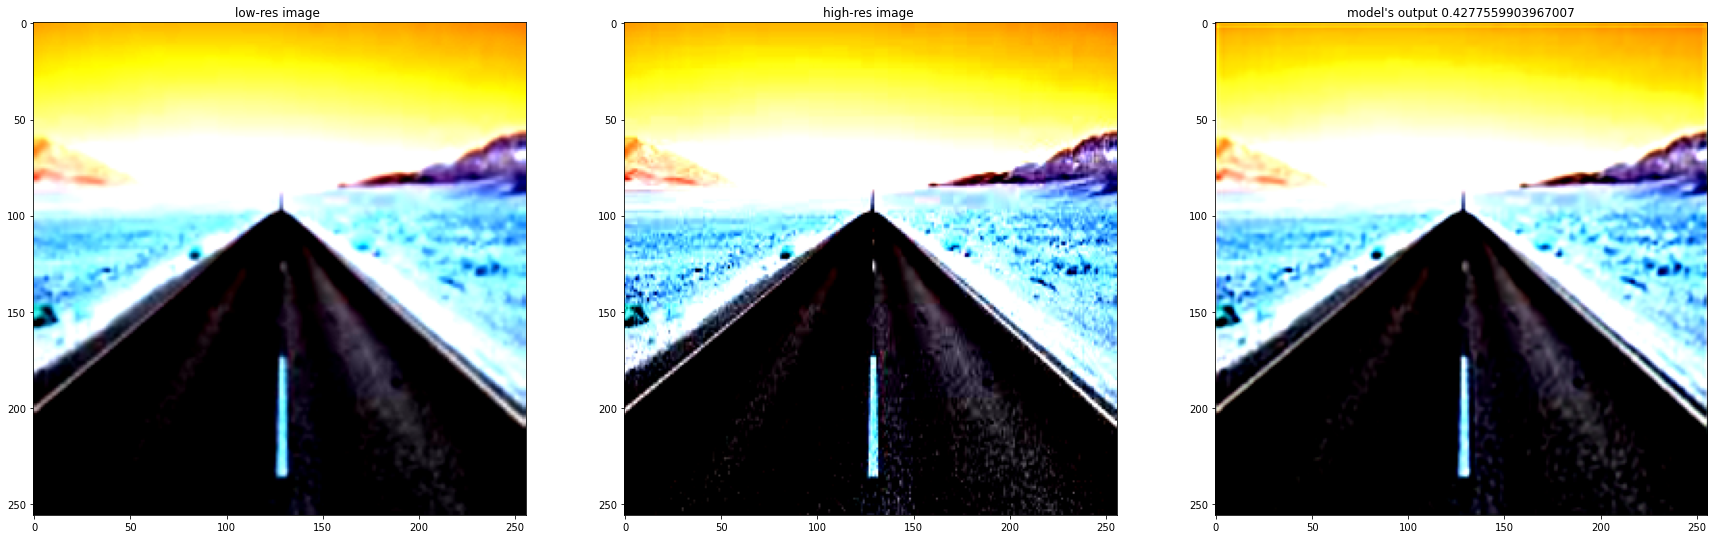

<Figure size 2160x2160 with 0 Axes>

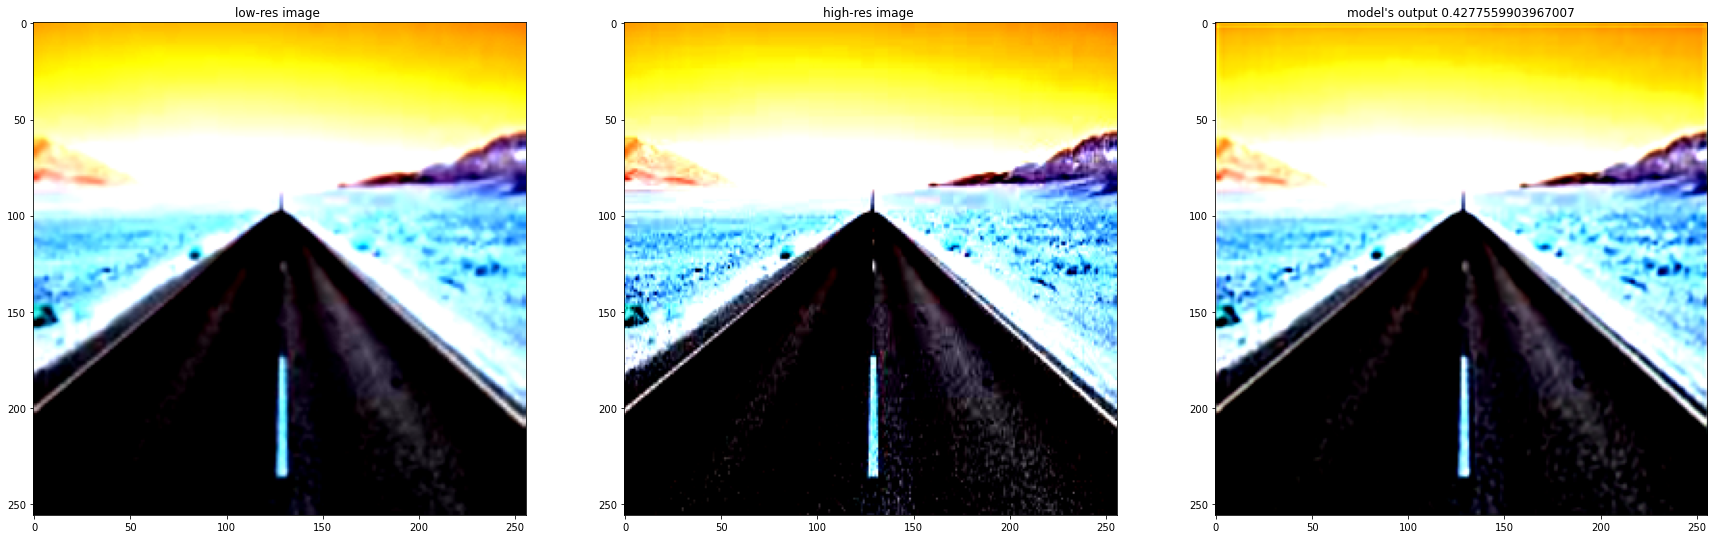

<Figure size 2160x2160 with 0 Axes>

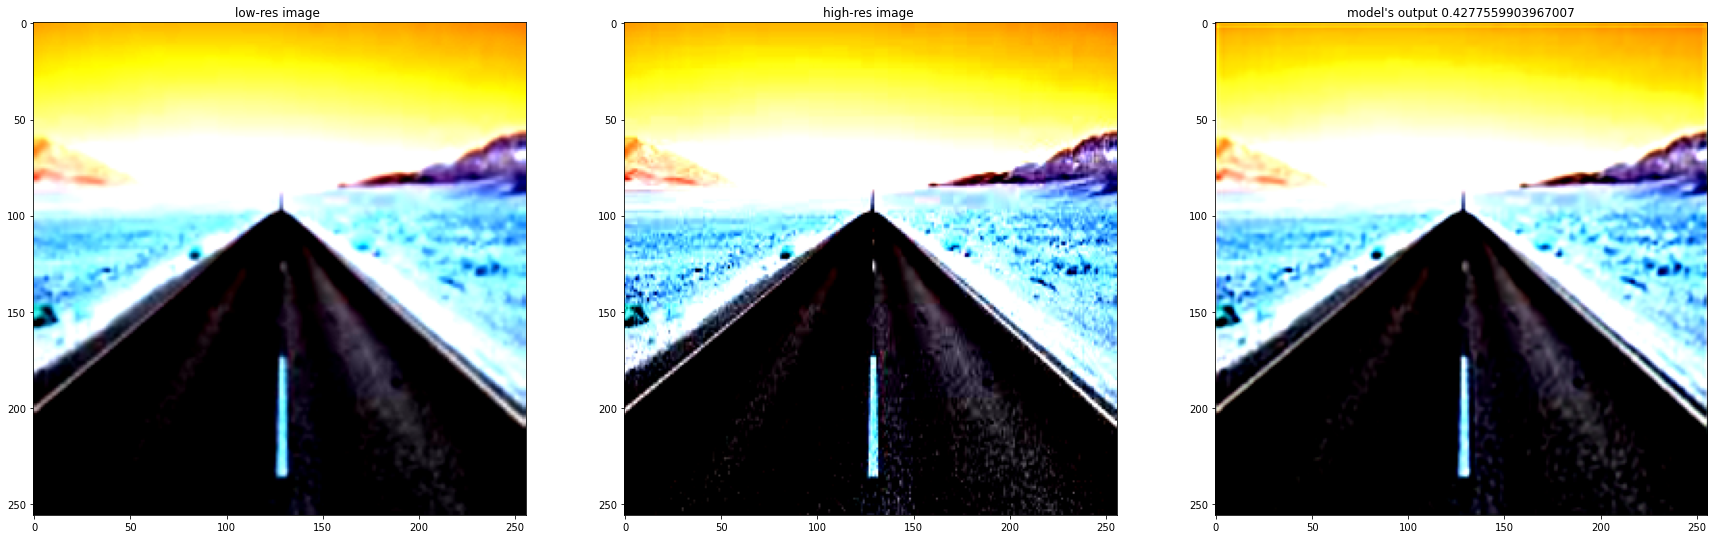

<Figure size 2160x2160 with 0 Axes>

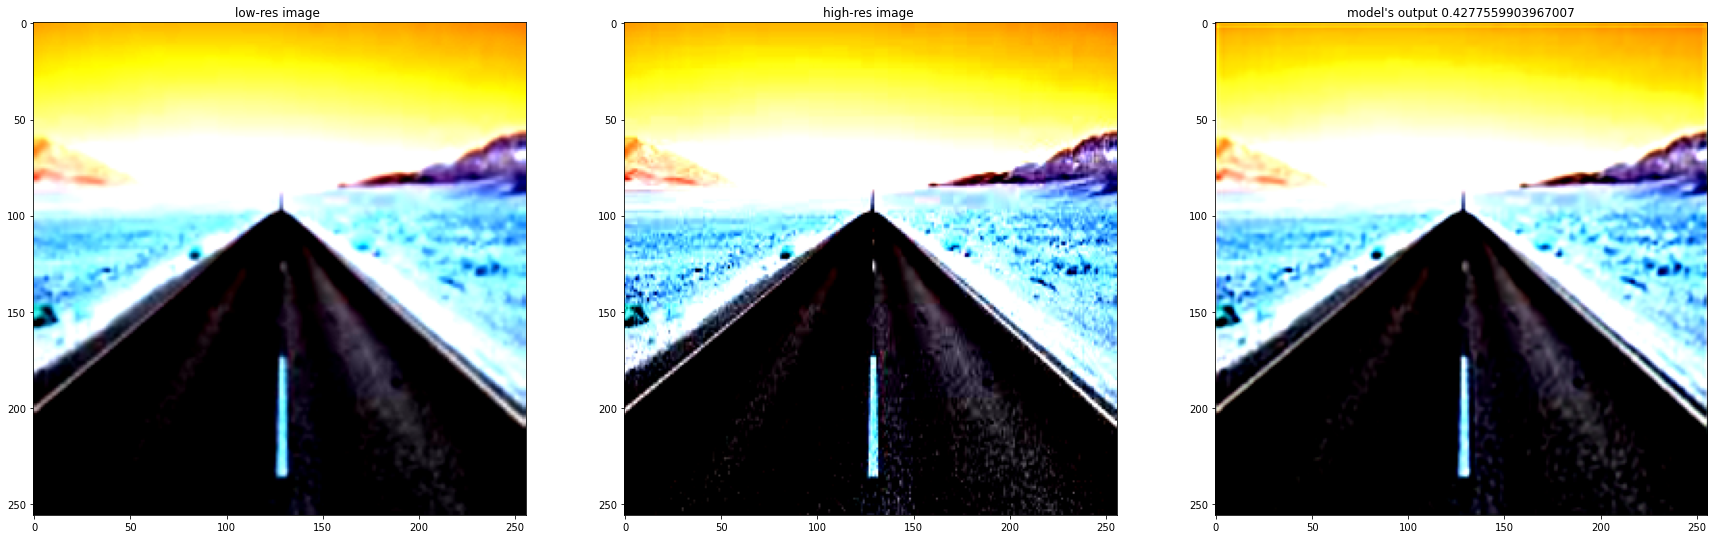

<Figure size 2160x2160 with 0 Axes>

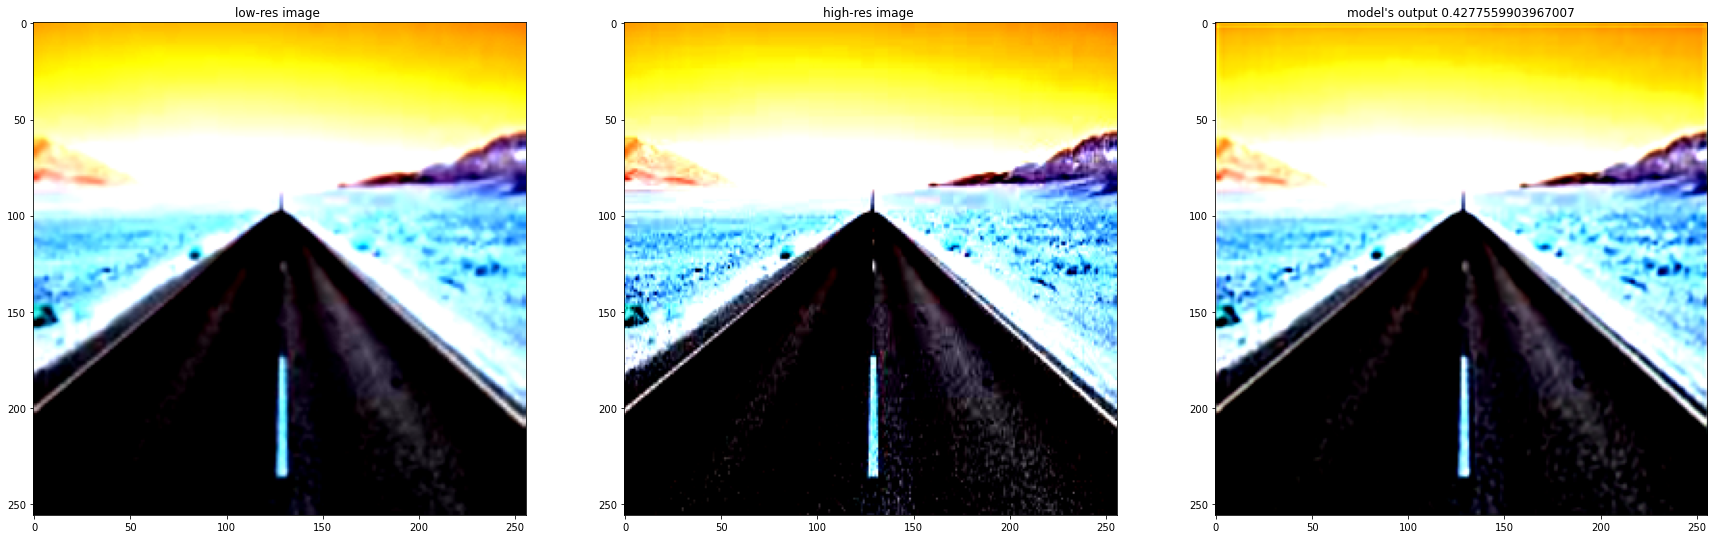

<Figure size 2160x2160 with 0 Axes>

In [392]:
%matplotlib inline
def plot_image(mse, arg_sort, span, best=True):
    def plot_helper(mse, arg_sort, index):
        val_index = arg_sort[index]
        mse_value = mse[index]
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))
        plt.figure(figsize=(30,30))
        ax1.imshow(val_x[val_index])
        ax1.title.set_text("low-res image ")
        ax2.imshow(val_y[val_index])
        ax2.title.set_text("high-res image ")
        ax3.imshow(val_pred[val_index])
        ax3.title.set_text(f"model's output {mse_value}")
    
    if best:
        for index in range(0, span):
            plot_helper(mse, arg_sort, span)
    else: 
        for index in range(-1, -1 -span, -1):
            plot_helper(mse, arg_sort, index)
        
        
plot_image(pred_mse, pred_arg_sort, 5, best=True)
